# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_imputeScale import pipe_supervisedSelector, pipe_imputation_scaling 
import shap
import pickle

from sklearn.pipeline import Pipeline
from func_preprocess import read_data, subset_wo_missigness, remove_NA, parseVariables, clean_data, impute_scale 
import matplotlib.colors




IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
translateVarsNames = {
    "gender":"gender",
    "age_erstmanifestation":"age at disease onset",
    "Diagnosedauer":"time to diagnosis",
    "achrak_rb":"Anti-AChR ab",
    "antimuskak_rb":"Anti-MuSK ab",
    "pyridostigmin_sprb":"medication with pyridostigmine",
    "thymektomie_gr":"thymectomy",
    "immuntherapie_grrb":"therapy with immunosuppressants",
    "exazerbationstherapie_grrb":"excerbation therapy",
    "eskalationstherapiebeitherapierefraktaerermyasthenie_grrb":"escalation therapy",
    "autoimmunerkrankungen_rbzu":"autoimmune diseases (other)",
    "scoreadl_neu":"MG-ADL",
    "mgfaklassifikation_schlimmste_historisch_rb":"MGFA (worst)",
    "aktuelle_MGFA_umkodiert":"MGFA (current)",
    "muskelschmerz":"muscle pain",
    "zn_myasthener_exazerbation":"previous MG exacerbation",
    "chronicfatigue_neu":"chronic fatigue",
    "chronicfatigue_normalised":"chronic fatigue",
    "seelischesbefinden_neu": "HADS",
    "generalisiertemuskelschwaeche": "generalisiertemuskelschwaeche",
    'thymom_ja_nein':"Thymom (y/n)", 
    'thymushyperlasie_ja_nein':"Hyperplasie (y/n)",
    'thymus_unauffällig_ja_nein':"Thymus auffaellig (y/n)"
}

In [3]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
varSet = 'natural' #"fullRegistry"
n_iter = 300


percentBoruta = 100
varFolder = "boruta"
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    

# varFolder = "manual"
# vars = "partiallyValidated" #"forceHisto"

''' 
Select features
'''

varPath = f"{PATH}/results/20_featureSelection/{varSet}/{varFolder}/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Define paths
'''
resultsPath = f"{PATH}/results/30_internalValidation/{varSet}/{vars}"
folderFigures = f'{PATH}/figures/publication/{varSet}'


''' 
Split data
'''
data = read_data(PATH,FILENAME=f"{varSet}")
X_orig = data.drop(target, axis=1)
y_orig = data[target]

print(X_orig.shape)
print(y_orig.value_counts())



LOADING DATA
(1814, 16)
gender
1    1019
0     795
Name: count, dtype: Int64


In [4]:
data.columns

Index(['zn_myasthener_krise_jn', 'zn_myasthener_exazerbation',
       'aktueller_mgfa_score', 'mgfaklassifikation_schlimmste_historisch_rb',
       'okulaer', 'bulbaer', 'generalisiertemuskelschwaeche', 'muskelschmerz',
       'autoimmunerkrankungen_rbzu', 'achrak_rb', 'antimuskak_rb',
       'age_erstmanifestation', 'scoreadl_neu', 'chronicfatigue_neu',
       'seelischesbefinden_neu', 'gender', 'chronicfatigue_normalised'],
      dtype='object')

In [5]:
''' Load SHAP'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_shap.pickle', 'rb') as f:
    dic_shap = pickle.load(f)
### sort
dic_shap = dict(sorted(dic_shap.items()))

average_shap_values = []
for k,v in dic_shap.items():
    average_shap_values.append(np.array(v).mean(axis=0)) 

In [6]:
''' 
Prepare dataframe for plotting
'''
num_columns = X_orig.loc[:,sel_variables].select_dtypes(include=["float64"]).columns
bin_columns = X_orig.loc[:,sel_variables].select_dtypes(include=["int64"]).columns
cat_columns = X_orig.loc[:,sel_variables].select_dtypes(include=["object"]).columns
preprocessor = pipe_imputation_scaling(num_columns, bin_columns, cat_columns)  


pipe = Pipeline([("selector", pipe_supervisedSelector(sel_variables)),
                ("imputation", preprocessor)])
X_imputed_plotting = pipe.fit_transform(X_orig)
columnOrderAfterPreprocessing = [ele[5:] for ele in pipe["imputation"].get_feature_names_out()]
df_plotting = pd.DataFrame(X_imputed_plotting[list(dic_shap.keys())], columns=columnOrderAfterPreprocessing)

### INverse transform numerical variables to add to interpretability
num_inverseTransform = pipe[1].transformers_[0][1][1].inverse_transform(df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()])
df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()] = num_inverseTransform


## Manually binarise
bin_inverseTransform = df_plotting.loc[:,pipe[1].transformers_[1][2].tolist()]
bin_inverseTransform[bin_inverseTransform > 0.5] = 1
bin_inverseTransform[bin_inverseTransform < 0.5] = 0
df_plotting.loc[:,pipe[1].transformers_[1][2].tolist()] = bin_inverseTransform


##### Fix names
df_plotting.columns = [translateVarsNames[ele] for ele in columnOrderAfterPreprocessing]
df_plotting

,age at disease onset,MG-ADL,HADS,chronic fatigue,autoimmune diseases (other)
0,61.000000,1.000000,22.000000,0.575758,0.0
1,39.000000,15.000000,11.000000,0.333333,0.0
2,54.000000,9.000000,22.000000,0.636364,0.0
3,64.000000,1.009969,21.174877,0.426374,0.0
4,51.382787,6.459930,10.999058,0.519704,0.0
...,...,...,...,...,...
1809,58.000000,0.000000,3.000000,0.393939,0.0
1810,45.000000,4.970333,9.753884,0.547672,0.0
1811,45.837538,8.354321,8.491696,0.420178,0.0
1812,18.000000,8.492827,0.000000,0.393939,0.0


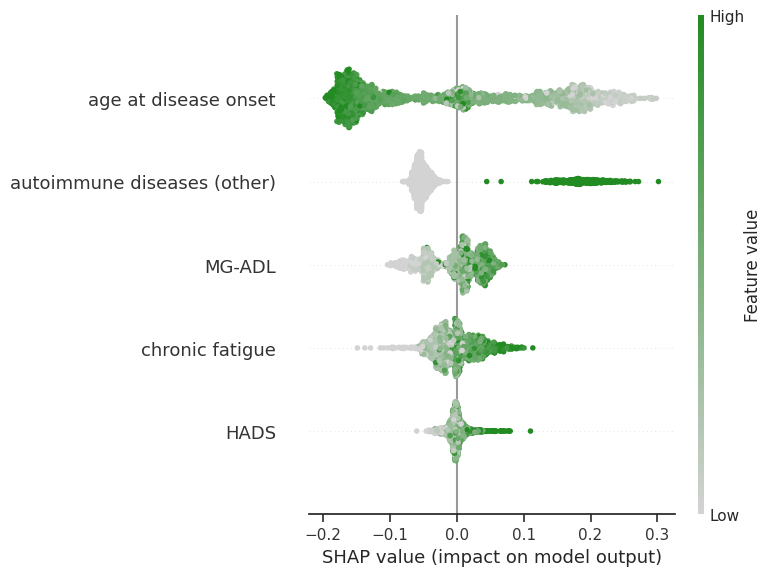

In [9]:
cmap_custom =  matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","forestgreen"]) #black

sns.set_theme(style="white", font_scale=1.2)
shap.summary_plot(np.array(average_shap_values), 
                  features=df_plotting,
                  show = False, sort=True, plot_size=(8.0,6.0),
                  cmap=cmap_custom
                  )

plt.savefig(f"{folderFigures}/SHAP_n{n_iter}.png", dpi=300)
plt.savefig(f"{folderFigures}/SHAP_n{n_iter}.pdf", dpi=300)

In [8]:
df_plotting

,age at disease onset,time to diagnosis,MG-ADL,HADS,chronic fatigue,autoimmune diseases (other),thymectomy
0,61.000000,0.000000,1.000000,22.000000,0.575758,0.0,0.0
1,39.000000,2.000000,15.000000,11.000000,0.333333,1.0,1.0
2,54.000000,3.000000,9.000000,22.000000,0.636364,0.0,1.0
3,64.000000,0.000000,5.156334,11.736554,0.508183,0.0,0.0
4,32.793466,2.118577,4.585933,23.933984,0.397721,0.0,0.0
...,...,...,...,...,...,...,...
1809,58.000000,0.000000,0.000000,3.000000,0.393939,0.0,1.0
1810,45.000000,0.000000,12.732048,24.404576,0.805605,0.0,0.0
1811,31.532632,0.009068,3.158271,8.358183,0.486171,0.0,0.0
1812,18.000000,1.000000,5.743454,0.000000,0.393939,0.0,1.0


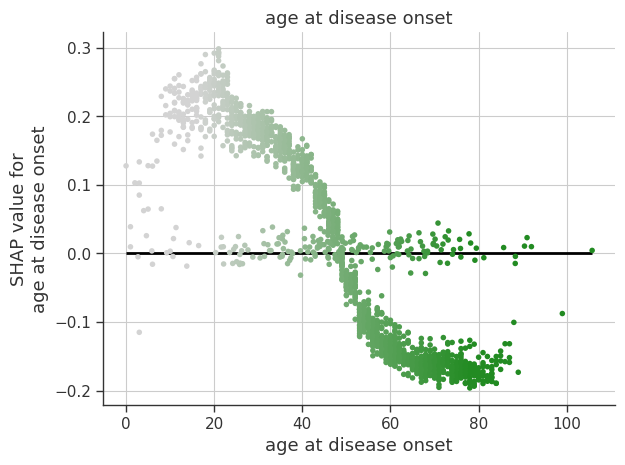

In [8]:
cmap_custom =  matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","forestgreen"]) #black

sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")

for i,a in enumerate(df_plotting.loc[:,["age at disease onset"]]):
    fig, ax = plt.subplots(1,1)
    ax.hlines(y=0, xmin=0, xmax=df_plotting.loc[:,a].max(), linestyles="-", colors='black', alpha=1, linewidth=2,zorder=1)
    shap.dependence_plot(a, np.array(average_shap_values), 
                        df_plotting, 
                        interaction_index=a,
                        cmap=cmap_custom,
                        ax=ax, title=a, show=False)
    plt.tight_layout()
    #plt.savefig(f"{folderFigures}/SHAP_dependencePlot_{a}.png", dpi=300)
    plt.savefig(f"{folderFigures}/SHAP_dependencePlot_{a}.pdf", dpi=300)